Name: **Zeeshan Anjum**

Project Type: **Lane Detection**

Comment: **helper functions are used from https://github.com/udacity/CarND-LaneLines-P1**

In [171]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math
import numpy as np
from numpy.polynomial import Polynomial as P
import cv2
import tensorflow as tf
%matplotlib inline
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [189]:
PREV_LEFT_X1 = None
PREV_LEFT_X2 = None
PREV_RIGHT_X1 = None
PREV_RIGHT_X2 = None

def to_hsv(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size=3):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def filter_color(img):
    #Yellow Color Masking
    yellow_min = np.array([65, 80, 80], np.uint8)
    yellow_max = np.array([105, 255, 255], np.uint8)
    yellow_mask = cv2.inRange(img, yellow_min, yellow_max)
    #White Color Masking
    white_min = np.array([0, 0, 200], np.uint8)
    white_max = np.array([255, 200, 255], np.uint8)
    white_mask = cv2.inRange(img, white_min, white_max)

    img = cv2.bitwise_and(img, img, mask=cv2.bitwise_or(yellow_mask, white_mask))
    return img

def region_of_interest(img, vertices):   
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def slope(line):
    return (float(line[3]) - line[1]) / (float(line[2]) - line[0])


def draw_lines(img, lines, color=[255, 0, 0], thickness=7):
    global PREV_LEFT_X1, PREV_LEFT_X2, PREV_RIGHT_X1, PREV_RIGHT_X2
    left_x = []
    left_y = []
    right_x = []
    right_y = []
    if(lines != None and len(lines)>0):
        for line in lines:
            line = line[0]
            s = slope(line)

            if 0.3 > s > -0.3:
                continue
            if s < 0:
                if line[0] > img.shape[1] / 2 + 40:
                    continue
                left_x += [line[0], line[2]]
                left_y += [line[1], line[3]]
            else:
                if line[0] < img.shape[1] / 2 - 40:
                    continue
                right_x += [line[0], line[2]]
                right_y += [line[1], line[3]]
               
        y1 = int(img.shape[0])
        y2 = int(img.shape[0] / 2 + 90)

        if len(left_x) <= 1 or len(right_x) <= 1:
            if PREV_LEFT_X1 is not None:
                cv2.line(img, (int(PREV_LEFT_X1), y1), (int(PREV_LEFT_X2), y2), color, thickness)
                cv2.line(img, (int(PREV_LEFT_X2), y1), (int(PREV_RIGHT_X2), y2), color, thickness)
            return

        left_poly = P.fit(np.array(left_x), np.array(left_y), 1)
        right_poly = P.fit(np.array(right_x), np.array(right_y), 1)

        left_x1 = (left_poly - y1).roots()
        right_x1 = (right_poly - y1).roots()

        left_x2 = (left_poly - y2).roots()
        right_x2 = (right_poly - y2).roots()

        if PREV_LEFT_X1 is not None:
            left_x1 = int(PREV_LEFT_X1 * 0.7 + left_x1 * 0.3)
            left_x2 = int(PREV_LEFT_X2 * 0.7 + left_x2 * 0.3)
            right_x1 = int(PREV_RIGHT_X1 * 0.7 + right_x1 * 0.3)
            right_x2 = int(PREV_RIGHT_X2 * 0.7 + right_x2 * 0.3)

        PREV_LEFT_X1 = left_x1
        PREV_LEFT_X2 = left_x2
        PREV_RIGHT_X1 = right_x1
        PREV_RIGHT_X2 = right_x2

        roi_corners = np.array([[(right_x2,y2),
                (left_x2,y2),
                (left_x1,y1),
                (right_x1, y1)]], dtype=np.int32)
        
        img=cv2.fillPoly(img, roi_corners, [50,50,100])        
        
        cv2.line(img, (left_x1, y1), (left_x2, y2), color, thickness)
        cv2.line(img, (right_x1, y1), (right_x2, y2), color, thickness)
        cv2.rectangle(img,(right_x2+30, y2-10), (left_x2-30, y2-60),[2,2,2],-1)
     
    
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    img` should be the output of a Canny transform.        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((*img.shape, 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img


def weighted_img(img, initial_img, α=1., β=1., λ=0.):
    """
    initial_img = 1st image, α = weight of 1st image,
    img = 2nd image, β = weight of 2nd image, λ = white value
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)


# Main Pipeline

In [195]:
def process_image(base_img,guidance_blending=0.6):
    """
    This is the main pipeline for the lane detection.
    BLUR -> FILTER COLOR -> CANNY -> SELECT REGION OF INTEREST -> HOUGH LINES
    """
    
    #getting colummns and rows size, it would be helpful to get the width and height of a frame
    ysize = base_img.shape[0]
    xsize = base_img.shape[1]
    #converting RGB to HSV
    image = to_hsv(base_img)
    #Applying Gaussian Blur to remove noise
    image = gaussian_blur(image, 3)
    #filter color for yellow and white # 
    image = filter_color(image)
    #finding edges
    image = canny(image, 30, 170)
    #setting region of interest based on our camera postion and view
    image = region_of_interest(
        image,
        np.array(
            [[(20, ysize), (xsize / 2, ysize / 2 + 20), (xsize / 2, ysize / 2 + 20), (xsize - 20, ysize)]],
            dtype=np.int32
        )
    )
    #plt.figure(3)
    #plt.imshow(image)
    #calculating hough lines
    image = hough_lines(image, 1.2, np.pi / 90, 5, 30, 160)
            #merging orignal image with lane marker overlay image and
    return weighted_img(image, base_img, β=guidance_blending)

# Testing on Image

The history saving thread hit an unexpected error (OperationalError('database or disk is full',)).History will not be written to the database.


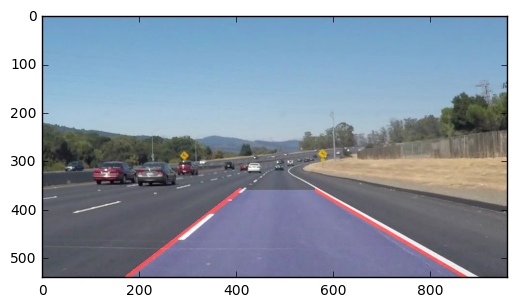

In [196]:
img = plt.imread('test.jpg')
test_img=process_image(img)#canny(gaussian_blur(img,7),10,170)
plt.figure(1)
plt.imshow(test_img)

# Testing on Video

In [198]:
#Challange Video
challange_clip='challenge.mp4'
challange_output='challenge_output.mp4'
#Solid White Right Lines
solid_white_right_clip='solidWhiteRight.mp4'
solid_white_right_output='solidWhiteRight_output.mp4'
#Solid Yellow Left Lines
solid_yellow_left_clip='solidYellowLeft.mp4'
solid_yellow_left_output='solidYellowLeft_output.mp4'

#Testing Video
new_clip = 'test.mp4'
new_clip_output = 'test_output.mp4'


#1st value is the video source, 2nd is the output file
process_video = [solid_yellow_left_clip,solid_yellow_left_output]


test_clip = VideoFileClip(process_video[0])
new_clip = test_clip.fl_image(lambda x: process_image(x))
%time new_clip.write_videofile(process_video[1], audio=False)

[MoviePy] >>>> Building video solidYellowLeft_output.mp4
[MoviePy] Writing video solidYellowLeft_output.mp4


100%|███████████████████████████████████████████████████████████████████████████████▉| 681/682 [00:24<00:00, 27.49it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: solidYellowLeft_output.mp4 

Wall time: 25.4 s


In [199]:
HTML("""<div style="background:black; border-radius:15px; color:white;"><center><h2 style="padding-top:22px">LANE DETECTION</h2><br/>
<video style="margin:10px; background:white; border-radius:15px" width="640" height="420" controls>
  <source src="{0}" type="video/mp4">
</video></center><div>
""".format(process_video[1]))